Our task is simple: unify and standardize ISO data sets into 1 dataframe
Here are the things we need to make sure we are doing:
- converting any timestamps or time associated data columns to datetime
- making sure that we are labeling where each sub data set comes from (e.g. ERCOT, SPP, etc.)
- making sure that we are able to apply transformations to datasets in 2 phases
    - phase 1: transformations on each ISO before merging to main df 
    - phase 2: transformations on the main df

In [14]:
import pandas as pd
import geopandas as gpd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import date, datetime, timedelta
import transform_lmp_data as tld

In [15]:
# allows us to define a date and from that assemble correct path refs
## today = date.today()  <-- only use this if you just pulled data today

# defining our date
today = "2025-05-17"  # should always be in the YYYY-MM-DD format

year_str = str(today)[:4]
month_str = str(today)[5:7]
day_str = str(today)[-2:]


print(today)
print(f'year string: {year_str}')
print(f'month string: {month_str}')
print(f'day string: {day_str}')

2025-05-17
year string: 2025
month string: 05
day string: 17


In [16]:
# loading in data that we have pulled
ercot_data = pl.read_csv(f'datasets/ercot_lmp_data/lmp_node_zone_hub_csv/{today}_lmp_node_zone_hub.csv')
spp_data = pl.read_csv(f'datasets/spp_lmp_data/LMP_By_SETTLEMENT_LOC/LMP_By_SETTLEMENT_LOC_{year_str}{month_str}{day_str}.csv')
nyiso_data = pl.read_csv(f'datasets/nyiso_lmp_data/realtime_zone/{year_str}{month_str}{day_str}.csv')
isone_data = pl.read_csv(f'datasets/isone_lmp_data/fiveminutelmp_csv/fiveminutelmp_{year_str}{month_str}{day_str}.csv')
caiso_data = pl.read_csv(f'datasets/caiso_lmp_data/lmp_csv_merged/{year_str}{month_str}{day_str}_lmp.csv')
pjm_data = pl.read_csv(f'datasets/pjm_lmp_data/rt_unverified_fivemin_lmps_csv/{month_str}-{day_str}-{year_str}.csv')
miso_data = pl.read_csv(f'datasets/miso_lmp_data/lmp_csv/{year_str}-{month_str}-{day_str}_lmp.csv')

In [17]:
# transforming our data sets before the main merge so that we can view it
ercot_df = tld.transform_ercot_data(ercot_df=ercot_data)
spp_df = tld.transform_spp_data(spp_df=spp_data)
nyiso_df = tld.transform_nyiso_data(nyiso_df=nyiso_data)
isone_df=tld.transform_isone_data(isone_df=isone_data)
caiso_df = tld.transform_caiso_data(caiso_df=caiso_data)
pjm_df = tld.transform_pjm_data(pjm_df=pjm_data)
miso_df = tld.transform_miso_data(miso_df=miso_data)

ercot_df.describe()
spp_df.describe()
nyiso_df.describe()
isone_df.describe()
caiso_df.describe()
pjm_df.describe()
miso_df.describe()

statistic,preliminaryFinal,node_id,5min_lmp,mcc,mec,mlc,resolution,start_time,timestamp,interval_value,iso_id,hour
str,str,str,f64,f64,f64,f64,str,str,str,str,str,f64
"""count""","""716000""","""716000""",716000.0,716000.0,716000.0,716000.0,"""716000""","""716000""","""716000""","""716000""","""716000""",716000.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""",0.0
"""mean""",null,null,21.497018,-9.417335,31.847874,-0.933521,null,null,"""2025-05-17 12:02:14.607821""",null,null,11.504112
"""std""",null,null,37.807744,37.835529,16.527779,2.201639,null,null,null,null,null,6.920012
"""min""","""Preliminary""","""AECI""",-1005.4,-1031.84,5.12,-27.84,"""5min""","""2025-05-17T00:00:00.000000""","""2025-05-17 00:05:00""","""2025-05-17 00:00:00.0""","""MISO""",0.0
"""25%""",null,null,8.67,-24.94,21.8,-1.69,null,null,"""2025-05-17 06:00:00""",null,null,6.0
"""50%""",null,null,20.86,-5.02,27.27,-0.48,null,null,"""2025-05-17 12:00:00""",null,null,12.0
"""75%""",null,null,26.96,0.0,35.51,0.31,null,null,"""2025-05-17 18:00:00""",null,null,18.0
"""max""","""Preliminary""","""YAD""",621.72,589.91,113.83,11.66,"""5min""","""2025-05-17T23:55:00.000000""","""2025-05-18 00:00:00""","""2025-05-17 23:55:00.0""","""MISO""",23.0


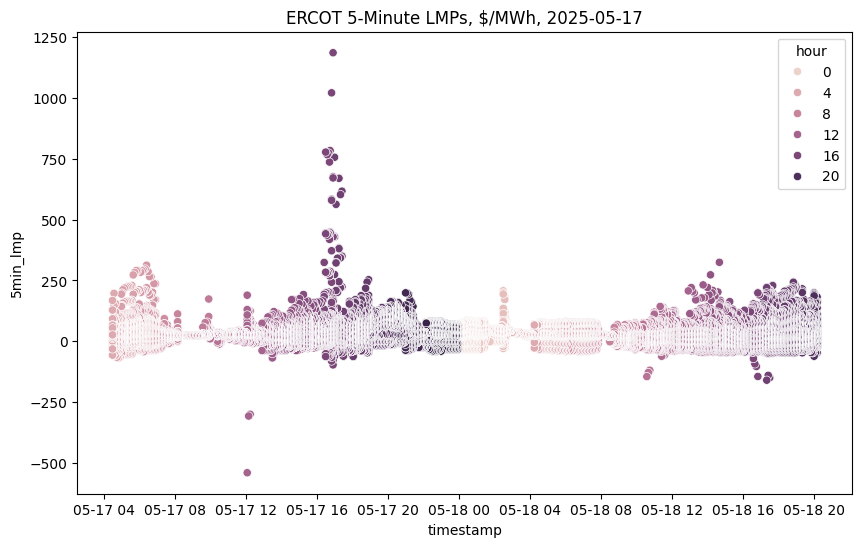

In [18]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=ercot_df, x='timestamp', y='5min_lmp', hue='hour')
plt.title(f'ERCOT 5-Minute LMPs, $/MWh, {today}')
plt.show()

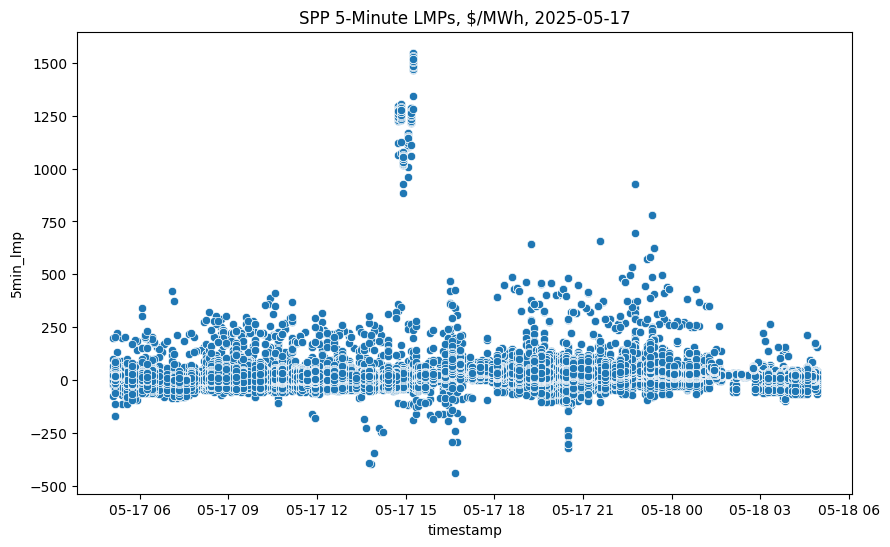

In [19]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=spp_df, x='timestamp', y='5min_lmp')
plt.title(f'SPP 5-Minute LMPs, $/MWh, {today}')
plt.show()

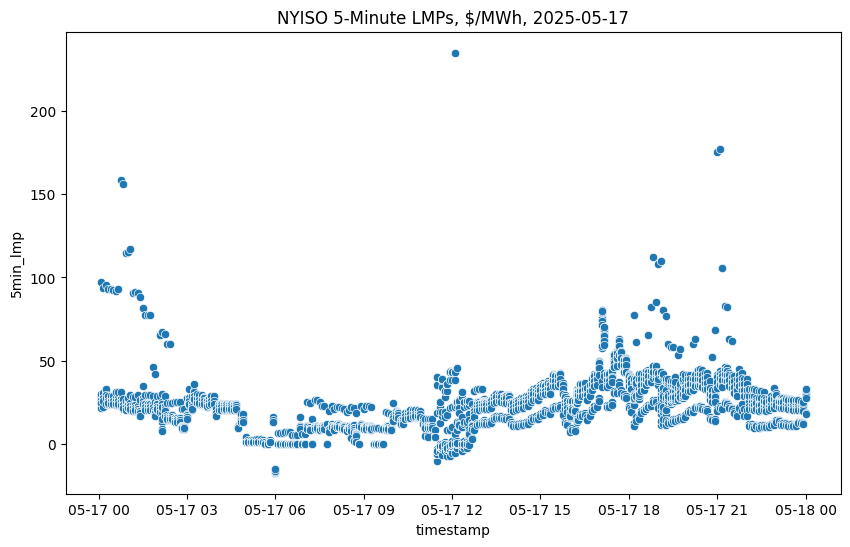

In [20]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=nyiso_df, x='timestamp', y='5min_lmp')
plt.title(f'NYISO 5-Minute LMPs, $/MWh, {today}')
plt.show()

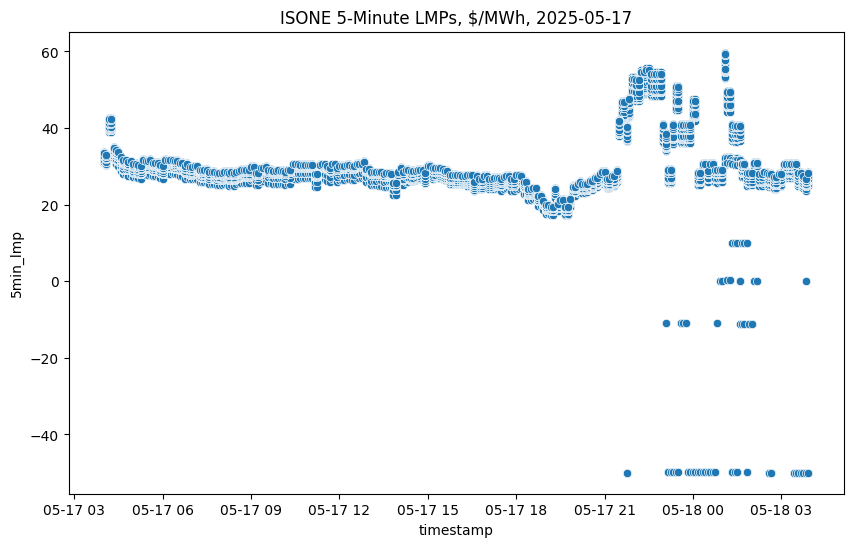

In [21]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=isone_df, x='timestamp', y='5min_lmp')
plt.title(f'ISONE 5-Minute LMPs, $/MWh, {today}')
plt.show()

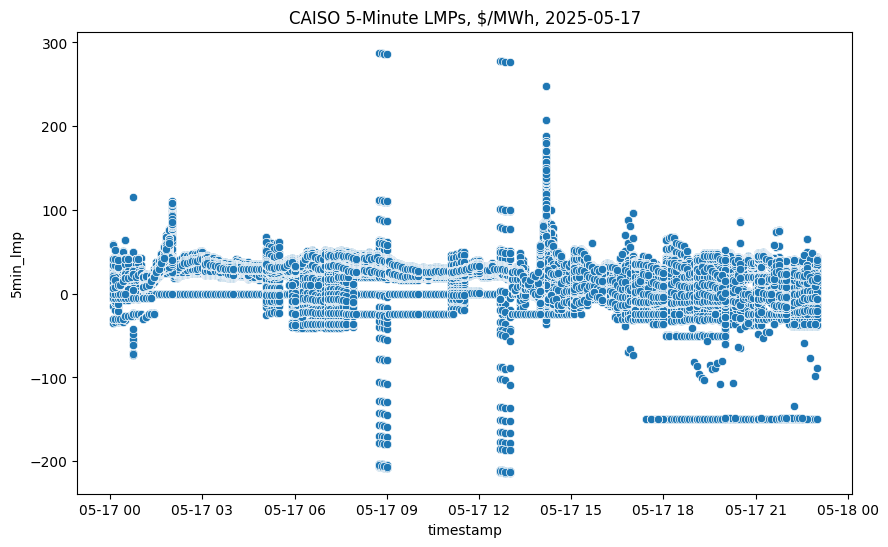

In [22]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=caiso_df, x='timestamp', y='5min_lmp')
plt.title(f'CAISO 5-Minute LMPs, $/MWh, {today}')
plt.show()

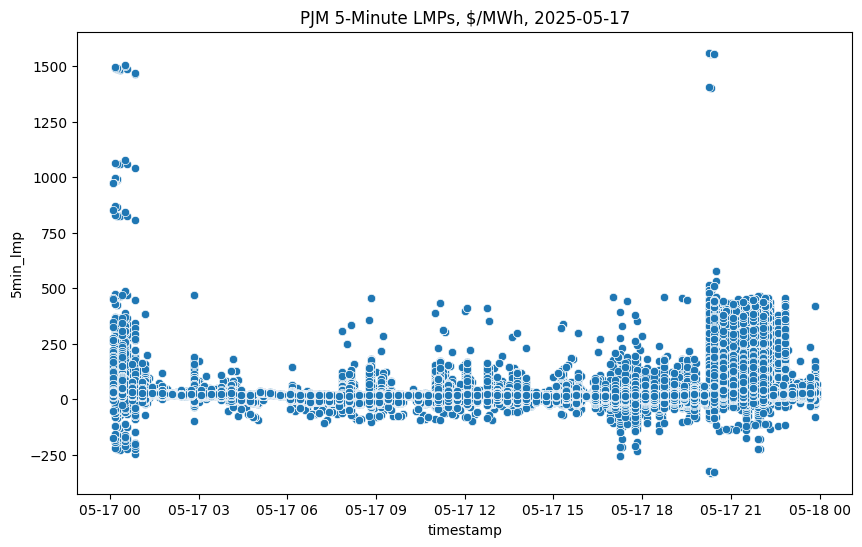

In [23]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=pjm_df, x='timestamp', y='5min_lmp')
plt.title(f'PJM 5-Minute LMPs, $/MWh, {today}')
plt.show()

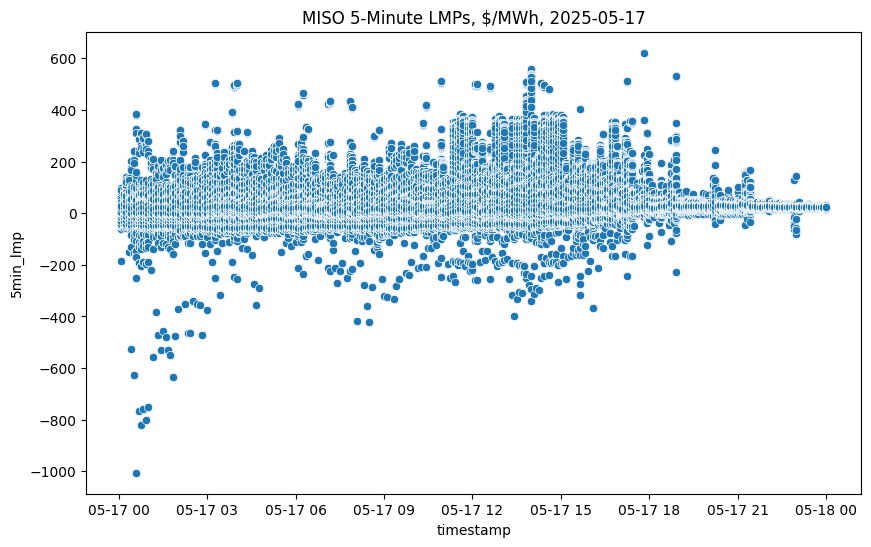

In [24]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=miso_df, x='timestamp', y='5min_lmp')
plt.title(f'MISO 5-Minute LMPs, $/MWh, {today}')
plt.show()

UNIFYING ISO DATA INTO 1 YAY! 10 MILLION DATA POINTS PER DAY :P

In [25]:
# create list of datasets
datasets = [caiso_df, ercot_df, isone_df, miso_df, nyiso_df,
            pjm_df, spp_df]

# filter datasets to have the same columns
#cols_to_keep = ['node_id', 'timestamp', '5min_lmp', "iso_id"]
#datasets_filtered = [dataset.select(cols_to_keep) for dataset in datasets]       

# create a standardized timestamp on all datasets
datasets_fmt = tld.create_std_timestamp(dataframes=datasets, 
                                    cols_keep=['node_id', 'timestamp', '5min_lmp', "iso_id"])

datasets_fmt.describe()

statistic,node_id,timestamp,5min_lmp,iso_id,formatted_timestamp
str,str,str,f64,str,str
"""count""","""10328848""","""10328848""",1.0328848e7,"""10328848""","""10328848"""
"""null_count""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,"""2025-05-17 12:35:44.128596""",22.59963,null,null
"""std""",null,null,22.328119,null,null
"""min""",""".H.INTERNAL_HUB""","""2025-05-17 00:05:00""",-1005.4,"""CAISO""","""05-17-2025 00:05:00"""
"""25%""",null,"""2025-05-17 06:20:00""",15.71,null,null
"""50%""",null,"""2025-05-17 12:20:00""",22.82,null,null
"""75%""",null,"""2025-05-17 18:20:00""",29.3723,null,null
"""max""","""ZULAJCT 69 KV LD_185""","""2025-05-18 20:10:00""",1560.41,"""SPP""","""05-18-2025 20:10:00"""


We have successfully pulled data for a given day across the united states, yay!
Now, let's create the following visuals
1. facet grid that shows 5 minute lmp data by ISO
2. facet grid that shows 5 minute lmp data by Hour and (hue) ISO
3. scatter plot that shows 5 minute lmp data by ISO (hue=ISO)

